In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import numpy as np
import matplotlib.pyplot as plt
import csv
import math
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import statsmodels.api as sm
import scipy
import seaborn as sns

# IMPORT MY LATEX SO I CAN USE \TEXTSC
import matplotlib as mpl
mpl.rc('text', **{'usetex':True})
import re
plt.rc( 'font', family = 'serif')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
charm_intrasocket_latency_f = '../data/2021_08_14_17_08_06_osu_latency_charm_pe0_64.csv'
charm_intersocket_latency_f = '../data/2021_08_14_17_08_06_osu_latency_charm_pe0_64.csv'
intra_socket = pd.read_csv(charm_intrasocket_latency_f, skiprows=1)
intra_groupsize = pd.read_csv('../data/2021_08_16_07_45_39_osu_latency_charm_pe_0_4_groupsize20.csv', skiprows=1)
inter_socket = pd.read_csv(charm_intersocket_latency_f, skiprows=1)

FileNotFoundError: [Errno 2] No such file or directory: '../data/2021_08_14_17_08_06_osu_latency_charm_pe0_64.csv'

In [29]:
# Data transformations
# To begin, the first 50 iterations in the Charm benchmark are 
# warmup, they should be skipped.
remove_warmup = lambda x: x.loc[x['Iteration Group'] >= 50]
intra_group = remove_warmup(intra_groupsize)
intra_socket = remove_warmup(intra_socket)
intra_socket = remove_warmup(inter_socket)
is_time = intra_socket.loc[intra_socket['Message Size']==1]['Elapsed seconds']*1e6
print(is_time)
# sm.qqplot((is_time,), fit=True, line="45")
ci = scipy.stats.bootstrap((is_time,), statistic=np.mean,confidence_level=0.99)
print(ci)
ci_width = ci.confidence_interval.high-ci.confidence_interval.low
print((ci_width-is_time.mean())/is_time.mean())

5      2.0559
6      1.8895
7      1.8014
8      1.8054
9      1.8335
        ...  
100    1.8264
101    1.8795
102    1.8073
103    1.8004
104    1.8185
Name: Elapsed seconds, Length: 100, dtype: float64
BootstrapResult(confidence_interval=ConfidenceInterval(low=1.829160458477964, high=1.8665271560745342), standard_error=0.0071315881194992095)
-0.979744621119077


In [26]:
9.146475623729379e-7*1e6

0.9146475623729379

2.0742513568197824e-18


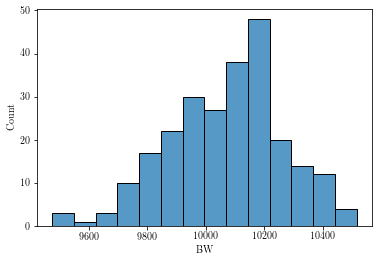

In [50]:
# Does enabling/disabling output writing affect bandwidth at 1mib?
import scipy.stats
enabled = pd.read_csv('../microbenchmarks/run_1mib_enabled')
disabled = pd.read_csv('../microbenchmarks/run_1mib_disabled')

vals = list()
# data = {'enabled': enabled['BW'], 'disabled': disabled['BW']}
# ci = scipy.stats.bootstrap((enabled,), statistic=np.mean,confidence_level=0.99)
# sm.qqplot(enabled['BW'], fit=True, line="45")
# sm.qqplot(disabled['BW'], fit=True, line="45")
sns.histplot(enabled.loc[enabled['BW'] > 8000]['BW'])
# print(ci)
# ci = scipy.stats.bootstrap((disabled,), statistic=np.mean,confidence_level=0.99)
# print(ci)
# stat, p = scipy.stats.mannwhitneyu(enabled['BW'],disabled['BW'])
print(p)
# if p < 0.05:
#     print("They are different")
# data = pd.DataFrame(data)
# print(data)|
# import seaborn as sns
# sns.violinplot(enabled)
# sns.violinplot(data['disabled'])

<AxesSubplot:xlabel='BW', ylabel='Count'>

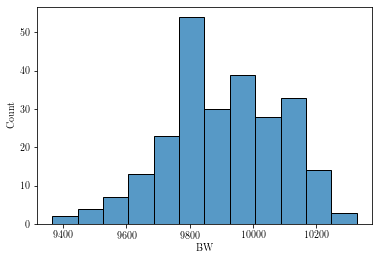

In [48]:
sns.histplot(disabled['BW'])

In [2]:
charm_intra_latency_f = '../data/microbenchmarks/2021_08_18_08_19_15_charm_lat_intrasocket.csv'
charm_inter_latency_f = '../data/microbenchmarks/2021_08_18_08_19_36_charm_lat_intersocket.csv'
mpi_intra_latency_f = '../data/microbenchmarks/2021_08_18_08_20_05_mpi_lat_intrasocket.csv'
mpi_inter_latency_f = '../data/microbenchmarks/2021_08_18_08_20_27_mpi_lat_intersocket.csv'

charm_interhost_bw_f = "../data/microbenchmarks/2021_08_18_08_51_19_charm_bw_internode.csv"
mpi_interhost_bw_f = "../data/microbenchmarks/2021_08_18_08_54_46_mpi_bw_internode.csv"
charm_intra_bw_f = ""
mpi_intra_bw_f = ""
charm_inter_bw_f = ""
mpi_intra_bw_f = ""

charm_intra_lat = pd.read_csv(charm_intra_latency_f, skiprows=1)
charm_inter_lat = pd.read_csv(charm_inter_latency_f, skiprows=1)

mpi_intra_lat = pd.read_csv(mpi_intra_latency_f, skiprows=1)
mpi_inter_lat = pd.read_csv(mpi_inter_latency_f, skiprows=1)

charm_interhost_bw = pd.read_csv(charm_interhost_bw_f, skiprows=1)
mpi_interhost_bw = pd.read_csv(mpi_interhost_bw_f, skiprows=1)

In [340]:


message_sizes = map(float, [1<<x for x in range(0, 23)])
for message_size in message_sizes:
    charm_intra = charm_intra_lat.loc[charm_intra_lat['Message size'] == message_size][3::]['Latency (us)']
    mpi_intra = mpi_intra_lat.loc[mpi_intra_lat['Message size'] == message_size][3::]['Latency (us)']
    ci_charm = scipy.stats.bootstrap((charm_intra,), statistic=np.mean,confidence_level=0.99)
    ci_mpi = scipy.stats.bootstrap((mpi_intra,), statistic=np.mean,confidence_level=0.99)
    ci_charm = (ci_charm.confidence_interval.low,ci_charm.confidence_interval.high)
    ci_mpi = (ci_mpi.confidence_interval.low,ci_mpi.confidence_interval.high)
    charm_percdiff = (((ci_charm[1]-ci_charm[0])-np.mean(charm_intra)))/np.mean(charm_intra)
    print(f"message size: {message_size} charm_mean: {np.mean(charm_intra)}, ci: {ci_charm}, diff: {charm_percdiff}")
    print(f"message size: {message_size} mpi_mean: {np.mean(mpi_intra)}, ci: {ci_mpi}")

message size: 1.0 charm_mean: 8.942912, ci: (8.902207810186326, 8.998667232015446), diff: -0.9892138688349924
message size: 1.0 mpi_mean: 1.138953, ci: (1.0241506645408887, 1.1659464456539803)
message size: 2.0 charm_mean: 8.849341500000001, ci: (8.813088158375376, 8.890852464890347), diff: -0.9912124188545587
message size: 2.0 mpi_mean: 1.1391535, ci: (1.0231326052402188, 1.165453236696771)
message size: 4.0 charm_mean: 8.834763500000001, ci: (8.801199316980822, 8.875244881808458), diff: -0.9916188401842748
message size: 4.0 mpi_mean: 1.1372945, ci: (1.0094444801774047, 1.1645424999999998)
message size: 8.0 charm_mean: 8.801767499999999, ci: (8.770153372418694, 8.841622312271646), diff: -0.9918801604503923
message size: 8.0 mpi_mean: 1.1417045000000001, ci: (1.0155131389812742, 1.1669465482948018)
message size: 16.0 charm_mean: 8.812100000000001, ci: (8.780560842083476, 8.851450308418213), diff: -0.9919554400954668
message size: 16.0 mpi_mean: 1.17202, ci: (1.035459962223659, 1.199773

[ 171.85445013  346.31661807  628.25178557 1112.68793505 1707.75798836
 2332.5951133  2192.51156445 2676.28203394 2943.44497277 3198.42171432
 3408.35009386 3445.80588371 3502.83715931]
[ 124.62157616  243.09432054  474.69040449  879.90195351 1564.17580161
 2825.8672572  4805.68640679 7264.14903843 1898.19526898 2319.12209453
 2601.51551776 2760.92496698 3796.29875593]


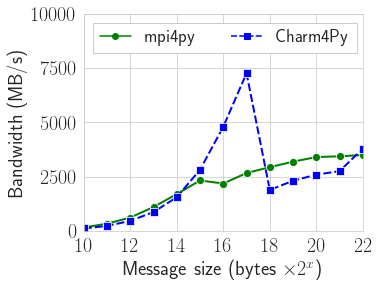

In [5]:
sns.set_style("whitegrid")
charm_data = charm_interhost_bw
mpi_data = mpi_interhost_bw
charm_data['framework'] = 'Charm4Py'
mpi_data['framework'] = 'mpi4py'
df = pd.concat([mpi_data, charm_data]).reset_index(drop=True)
df = df.loc[df['Message size'] >= 1<<10]
df['Message size'] = np.log2(df['Message size'])
df = df.loc[df['Iteration'] >= df['Warmup']]
f, ax = plt.subplots(figsize=(5,4))
pl=sns.lineplot(x="Message size", y="Bandwidth (MB/s)", data=df,hue="framework", 
              palette = ['green', 'blue'],ci=99,err_style="bars",
              markers=['o','s'],style="framework",linewidth=2, markersize=8)
lines = pl.lines[0]
print(lines.get_ydata())
print(pl.lines[2].get_ydata())
mpi4py_bw = pl.lines[0].get_ydata()
charm4py_bw = pl.lines[2].get_ydata()
pl.legend(fontsize = 18, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 2)
pl.tick_params( which = 'major', labelsize = 20 )
pl.set_xlim(10, 22)
pl.set_xticks(range(10,23,2))
pl.set_ylim(0,10000)
pl.set_yticks([0,2500,5000,7500,10000])
pl.set_ylabel('Bandwidth (MB/s)', fontsize=20)
pl.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('internode_bandwidth.pdf', bbox_inches='tight', dpi=300)

      Message size  Grouping  Total Iterations  Warmup  Latency (us) framework
0              1.0       0.0            1000.0    60.0     13.214700  Charm4Py
1              1.0      20.0            1000.0    60.0     10.786125  Charm4Py
2              1.0      40.0            1000.0    60.0     10.218525  Charm4Py
3              1.0      60.0            1000.0    60.0      9.019025  Charm4Py
4              1.0      80.0            1000.0    60.0      9.084650  Charm4Py
...            ...       ...               ...     ...           ...       ...
1797        1024.0     960.0            1000.0    60.0      1.682175    mpi4py
1798        1024.0     980.0            1000.0    60.0      1.679175    mpi4py
1799        1024.0    1000.0            1000.0    60.0      1.676900    mpi4py
1800        1024.0    1020.0            1000.0    60.0      1.682925    mpi4py
1801        1024.0    1040.0            1000.0    60.0      1.680450    mpi4py

[1166 rows x 6 columns]
      Message size  Groupin

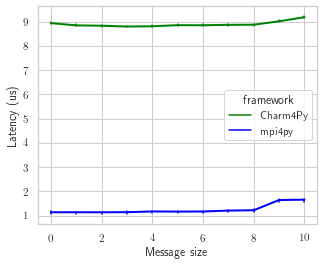

In [345]:
sns.set_style("whitegrid")
charm_data = charm_intra_lat
mpi_data = mpi_intra_lat
charm_data['framework'] = 'Charm4Py'
mpi_data['framework'] = 'mpi4py'
df = pd.concat([charm_data, mpi_data]).reset_index(drop=True)
df = df.loc[df['Message size'] < 1<<11]
print(df)
df['Message size'] = np.log2(df['Message size'])
df = df.loc[df['Grouping'] >= df['Warmup']]
print(df)
f, ax = plt.subplots(figsize=(5,4))
pl=sns.lineplot(x="Message size", y="Latency (us)", data=df,hue="framework", 
              palette = ['green','blue'],ax=ax,ci=99,err_style="bars",
              linewidth=2, markersize=8)
# pl=sns.boxplot(x="Message size", y="Latency (us)", data=df,hue="framework", 
#               palette = ['green', 'blue'])
# pl.set_yscale("log", base=2)
# onemib=df[df['Message size'] == 20]
# twomib=df[df['Message size'] == 21]
# onemib=onemib[onemib['Latency (us)'] > 8]
# twomib=twomib[twomib['Latency (us)'] > 8]
# print(min(onemib['Latency (us)']))
# onemib["size"] = "1mib"
# twomib["size"] = "2mib"
# df2=pd.concat([onemib,twomib])

# sns.boxplot(x="size", y="Latency (us)", data=df2)
# pl.legend(fontsize = 18, loc = 'upper left', fancybox = False, framealpha = 1,
#               handlelength = 1.7, ncol = 2)
# pl.tick_params( which = 'major', labelsize = 20 )
# pl.set_xlim(10, 22)
# pl.set_xticks(range(10,23,2))
# pl.set_ylim(0,10000)
# pl.set_yticks([0,2500,5000,7500,10000])
# pl.set_ylabel('Bandwidth (MB/s)', fontsize=20)
# pl.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)

Text(0.5, 0, 'Message size (bytes $\\times 2^x$)')

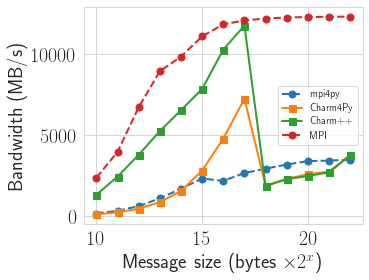

In [9]:
charmp_bw = [
1341.232,
2454.385,
3803.511,
5268.040,
6556.166,
7868.170,
10302.540,
11780.915,
1867.124,
2295.692,
2489.094,
2713.238,
3762.907
]

ompi_bw = [
2389.81,
3991.94,
6745.00,
8963.74,
9869.60,
11115.77,
11860.86,
12102.33,
12219.23,
12282.15,
12313.46,
12329.27,
12336.90
]
x_axis = range(10,23)
(len(ompi_bw), len(charmp_bw), len(charm4py_bw), len(mpi4py_bw))

fix, ax = plt.subplots(figsize=(5,4))
ax.plot(x_axis, mpi4py_bw, label="mpi4py",markersize = 7, linewidth = 2, ls='--', marker = 'o')
ax.plot(x_axis, charm4py_bw, label="Charm4Py",markersize = 7, linewidth = 2, ls='-', marker = 's')
ax.plot(x_axis, charmp_bw, label="Charm++",markersize = 7, linewidth = 2, ls='-', marker = 's')
ax.plot(x_axis, ompi_bw, label="MPI",markersize = 7, linewidth = 2, ls='--', marker = 'o')
ax.legend()

# mpi4py_bw = pl.lines[0].get_ydata()
# charm4py_bw = pl.lines[2].get_ydata()
# pl.legend(fontsize = 18, loc = 'upper left', fancybox = False, framealpha = 1,
#               handlelength = 1.7, ncol = 2)
ax.tick_params( which = 'major', labelsize = 20 )
# pl.set_xlim(10, 22)
# pl.set_xticks(range(10,23,2))
# pl.set_ylim(0,10000)
# pl.set_yticks([0,2500,5000,7500,10000])
ax.set_ylabel('Bandwidth (MB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
# plt.savefig('internode_bandwidth_allmodels.pdf', bbox_inches='tight', dpi=300)

In [37]:
# Calculate times for Charm, Charm4Py

a=charmp_bw[7]
# MB sent
size_a = (64 * (1<<17))/1e6

b = charmp_bw[8]
size_b = (64 * (1<<18))/1e6
a_time = (size_a/a)*1000
b_time = (size_b/b)*1000

print(a,b)
print(a/b)
print(a_time)
print(b_time)
print(a_time/b_time)
print(b_time-a_time)

11780.915 1867.124
6.309658597929222
0.7120506344371383
8.985592815474494
0.07924359016256377
8.273542181037355


In [129]:
basedir = '../data/microbenchmarks/2021-08-23_cleaned'
read_file = lambda x: pd.read_csv(f"{basedir}/{x}", comment='#')[['Msg Size', ' Bandwidth (MB/s)']]
rf = read_file

chpy = [rf('charm4py_intrasocket_bw.csv'), rf('charm4py_intersocket_bw.csv')]
ch = [rf('charm_intrasocket_bw.csv'), rf('charm_intersocket_bw.csv')]
mppy = [rf('mpi4py_intrasocket_bw.csv'), rf('mpi4py_intersocket_bw.csv')]
mp = [rf('mpi_intrasocket_bw.csv'), rf('mpi_intersocket_bw.csv')]


dfs = [*chpy, *ch, *mppy, *mp]
assert len(set([len(x) for x in dfs])) == 1

In [130]:
# Build one dataframe for inter and intra containing data for every framework
chpy[0]['framework'] = 'Charm4Py'
ch[0]['framework'] = 'Charm++'
mppy[0]['framework'] = 'mpi4py'
mp[0]['framework'] = 'MPI'

chpy[1]['framework'] = 'Charm4Py'
ch[1]['framework'] = 'Charm++'
mppy[1]['framework'] = 'mpi4py'
mp[1]['framework'] = 'MPI'
print(chpy[0]['Msg Size'])
intra_bw = pd.concat([chpy[0], ch[0], mppy[0], mp[0]]).reset_index(drop=True)
intra_bw = intra_bw[intra_bw['Msg Size'] >= 1<<4]
intra_bw['Msg Size'] = np.log2(intra_bw['Msg Size'])

inter_bw = pd.concat([chpy[1], ch[1], mppy[1], mp[1]]).reset_index(drop=True)
inter_bw = inter_bw[inter_bw['Msg Size'] >= 1<<4]
inter_bw['Msg Size'] = np.log2(inter_bw['Msg Size'])
print(inter_bw)

0            1
1            2
2            4
3            8
4           16
        ...   
225     262144
226     524288
227    1048576
228    2097152
229    4194304
Name: Msg Size, Length: 230, dtype: int64
     Msg Size   Bandwidth (MB/s) framework
4         4.0           1.207839  Charm4Py
5         5.0           2.420290  Charm4Py
6         6.0           4.816019  Charm4Py
7         7.0           9.580456  Charm4Py
8         8.0          19.176389  Charm4Py
..        ...                ...       ...
915      18.0       19401.160000       MPI
916      19.0       16810.790000       MPI
917      20.0       12168.930000       MPI
918      21.0        9651.630000       MPI
919      22.0        9358.200000       MPI

[760 rows x 3 columns]


/home/zane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


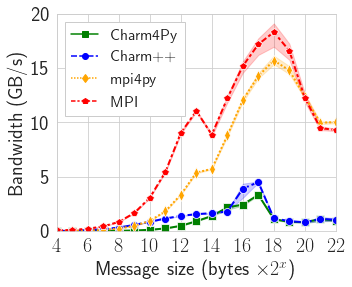

In [134]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=intra_bw,hue="framework", style="framework",
              palette = ['green','blue', 'orange', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=2, markersize=8)
ax.legend(fontsize = 16, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_ylim(0, 20000)
ax.set_yticklabels([0,5,10,15,20])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_bw_intrasocket.pdf', bbox_inches='tight', dpi=300)

/home/zane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


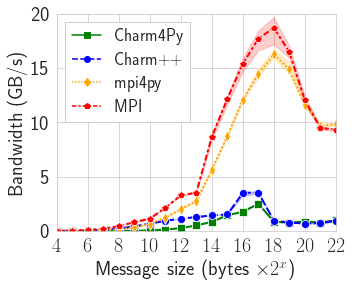

In [133]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=inter_bw,hue="framework", style="framework",
              palette = ['green','blue', 'orange', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=2, markersize=8)
ax.legend(fontsize = 17, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_ylim(0, 20000)
ax.set_yticklabels([0,5,10,15,20])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_bw_intersocket.pdf', bbox_inches='tight', dpi=300)


/home/zane/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


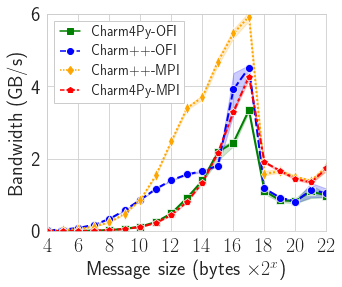

In [149]:



sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=intra_bw,hue="framework", style="framework",
              palette = ['green','blue', 'orange', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=2, markersize=8)
ax.legend(fontsize = 14, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.4, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_ylim(0, 6000)
ax.set_yticklabels([0,2,4,6])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('charms_bw_intrasocket_mpi_ofi.pdf', bbox_inches='tight', dpi=300)


In [20]:
# Data with MPI backend
basedir = '../data/microbenchmarks/2021-08-28_bandwidth_cleaned'
read_file = lambda x: pd.read_csv(f"{basedir}/{x}", comment='#')[['Msg Size', ' Bandwidth (MB/s)']]
rf = read_file

chpy_mpi = [rf('charm4py_intrasocket_bw.csv'), rf('charm4py_intersocket_bw.csv'),
           rf('charm4py_internode_bw.csv')]
ch_mpi = [rf('charm_intrasocket_bw.csv'), rf('charm_intersocket_bw.csv'),
         rf('charm_internode_bw.csv')]

mppy = [rf('mpi4py_intrasocket_bw.csv'), rf('mpi4py_intersocket_bw.csv'),
       rf('mpi4py_internode_bw.csv')]
mp = [rf('mpi_intrasocket_bw.csv'), rf('mpi_intersocket_bw.csv'),
     rf('mpi_internode_bw.csv')]


dfs = [*chpy_mpi, *ch_mpi, *mppy, *mp]

assert len(set([len(x) for x in dfs])) == 1

# Build one dataframe for inter and intra containing data for every framework
chpy_mpi[0]['framework'] = 'Charm4Py'
ch_mpi[0]['framework'] = 'Charm++'
mppy[0]['framework'] = 'mpi4py'
mp[0]['framework'] = 'MPI'

chpy_mpi[1]['framework'] = 'Charm4Py'
ch_mpi[1]['framework'] = 'Charm++'
mppy[1]['framework'] = 'mpi4py'
mp[1]['framework'] = 'MPI'

chpy_mpi[2]['framework'] = 'Charm4Py'
ch_mpi[2]['framework'] = 'Charm++'
mppy[2]['framework'] = 'mpi4py'
mp[2]['framework'] = 'MPI'

intra_bw = pd.concat([chpy_mpi[0], ch_mpi[0], mppy[0], mp[0]]).reset_index(drop=True)
intra_bw = intra_bw[intra_bw['Msg Size'] >= 1<<4]
intra_bw['Msg Size'] = np.log2(intra_bw['Msg Size'])

inter_bw = pd.concat([chpy_mpi[1], ch_mpi[1], mppy[1], mp[1]]).reset_index(drop=True)
inter_bw = inter_bw[inter_bw['Msg Size'] >= 1<<4]
inter_bw['Msg Size'] = np.log2(inter_bw['Msg Size'])


internode_bw = pd.concat([chpy_mpi[2], ch_mpi[2], mppy[2], mp[2]]).reset_index(drop=True)
internode_bw = internode_bw[internode_bw['Msg Size'] >= 1<<4]
internode_bw['Msg Size'] = np.log2(internode_bw['Msg Size'])

[1.58469392e+00 3.17648536e+00 6.38657521e+00 1.26832425e+01
 2.53401888e+01 5.04079122e+01 9.68918088e+01 1.90417607e+02
 3.74332751e+02 6.37230751e+02 1.15720087e+03 1.94097041e+03
 2.91903840e+03 3.99182092e+03 1.55105571e+03 1.59590659e+03
 1.57038379e+03 1.57662288e+03 2.13092260e+03]
[   7.4119   14.566    29.0991   58.252   115.5283  226.2172  415.5993
  789.4088 1412.6741 1692.1452 2502.9777 3405.825  4210.2474 4660.7638
 1522.3559 1422.4407 1382.4039 1360.1043 1666.5568]
25.655590169608868
24.816001090363905
24.624152725241807
24.05457413509741
22.51078986697531
26.250237881945573
29.89899360508658
35.794781293331646
46.78447615792625
41.137615151735424
36.682668640289016
34.970723605681236
33.99170618811309
32.000023893097335
9.526893194763836
9.353584166697352
11.59189743413437
14.390571639606883
18.032195650390964


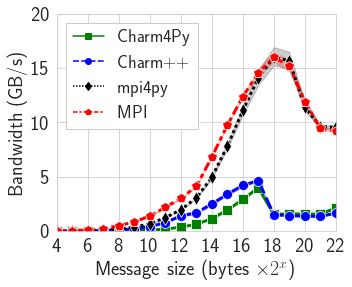

In [22]:
# Plot bandwidth with the MPI backend, intra-socket
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=intra_bw,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 18, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_xticklabels(range(4,23,2))
ax.set_ylim(0, 20000)
ax.set_yticks([0, 5000, 10000, 15000, 20000])
ax.set_yticklabels([0, 5, 10, 15, 20])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_bw_intrasocket_chmpi.pdf', bbox_inches='tight', dpi=300)

lines = ax.get_lines()
chp_lat = lines[0].get_ydata()
ch_lat = lines[1].get_ydata()
mpip_lat = lines[2].get_ydata()
mpi_lat = lines[3].get_ydata()
print(chp_lat)
print(ch_lat)
for ch, mpi in zip(ch_lat, mpi_lat):
    perc_diff = 100*ch/mpi
    print(perc_diff)


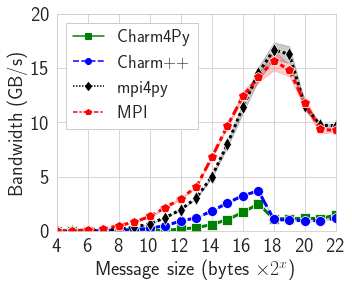

In [18]:
# Plot bandwidth with the MPI backend, inter-socket
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=inter_bw,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 18, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_xticklabels(range(4,23,2))
# ax.set_yscale('log', base=10)
ax.set_ylim(0, 20000)
ax.set_yticks([0, 5000, 10000, 15000, 20000])
ax.set_yticklabels([0, 5, 10, 15, 20])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_bw_intersocket_chmpi.pdf', bbox_inches='tight', dpi=300)

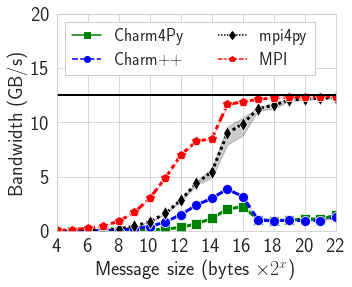

In [22]:
# Plot bandwidth with the MPI backend, inter-node
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=internode_bw,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 17, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 2)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_xticklabels(range(4,23,2))
# ax.set_yscale('log', base=10)
ax.set_ylim(0, 20000)
ax.set_yticks([0, 5000, 10000, 15000, 20000])
ax.set_yticklabels([0, 5, 10, 15, 20])
plt.axhline(y=12500, color='black', linestyle='-', linewidth=2)
# ax.set_yticks([1<<0, 1<<2, 1<<4, 1<<6, 1<<8, 1<<10, 1<<12, 1<<14])
# ax.set_yticklabels(
# ax.set_ylim(0, 20000)
# ax.set_yticklabels([0,5,10,15,20])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_bw_internode_chmpi.pdf', bbox_inches='tight', dpi=300)

In [117]:
# Latency data, used with the default rendezvous threshold, provides bad performance; not used in the paper.
# Data with MPI backend
basedir = '../data/microbenchmarks/2021-08-27_latency_cleaned'
read_file = lambda x: pd.read_csv(f"{basedir}/{x}", comment='#')[['Msg Size', ' One-way Time (us)']]
rf = read_file

chpy_mpi = [rf('charm4py_intrasocket_lat.csv'), rf('charm4py_intersocket_lat.csv'),
           rf('charm4py_internode_lat.csv')]
ch_mpi = [rf('charm_intrasocket_lat.csv'), rf('charm_intersocket_lat.csv'),
         rf('charm_internode_lat.csv')]

mppy = [rf('mpi4py_intrasocket_lat.csv'), rf('mpi4py_intersocket_lat.csv'),
       rf('mpi4py_internode_lat.csv')]
mp = [rf('mpi_intrasocket_lat.csv'), rf('mpi_intersocket_lat.csv'),
     rf('mpi_internode_lat.csv')]

dfs = [*chpy_mpi, *ch_mpi, *mppy, *mp]

# Will have 2 values because MPI starts at 0 bytes, not 1.
assert(len(set([len(x) for x in dfs])) == 2)

# Build one dataframe for inter and intra containing data for every framework
chpy_mpi[0]['framework'] = 'Charm4Py'
ch_mpi[0]['framework'] = 'Charm++'
mppy[0]['framework'] = 'mpi4py'
mp[0]['framework'] = 'MPI'

chpy_mpi[1]['framework'] = 'Charm4Py'
ch_mpi[1]['framework'] = 'Charm++'
mppy[1]['framework'] = 'mpi4py'
mp[1]['framework'] = 'MPI'

chpy_mpi[2]['framework'] = 'Charm4Py'
ch_mpi[2]['framework'] = 'Charm++'
mppy[2]['framework'] = 'mpi4py'
mp[2]['framework'] = 'MPI'

intra_lat = pd.concat([chpy_mpi[0], ch_mpi[0], mppy[0], mp[0]]).reset_index(drop=True)
intra_lat = intra_lat[intra_lat['Msg Size'] >= 1<<4]
intra_lat['Msg Size'] = np.log2(intra_lat['Msg Size'])

inter_lat = pd.concat([chpy_mpi[1], ch_mpi[1], mppy[1], mp[1]]).reset_index(drop=True)
inter_lat = inter_lat[inter_lat['Msg Size'] >= 1<<4]
inter_lat['Msg Size'] = np.log2(inter_lat['Msg Size'])


internode_lat = pd.concat([chpy_mpi[2], ch_mpi[2], mppy[2], mp[2]]).reset_index(drop=True)
internode_lat = internode_lat[internode_lat['Msg Size'] >= 1<<4]
internode_lat['Msg Size'] = np.log2(internode_lat['Msg Size'])

Text(0.5, 0, 'Message size (bytes $\\times 2^x$)')

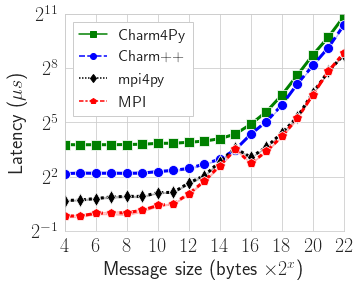

In [118]:
# Plot latency with the MPI backend, intra-socket
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=intra_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 16, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('log', base=2)
ax.set_ylim(0.5, 1<<11)
# ax.set_yticklabels([0,5,10,15,20])
ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
# plt.savefig('all_bw_intrasocket_chmpi.pdf', bbox_inches='tight', dpi=300)

2189.877539


Text(0.5, 0, 'Message size (bytes $\\times 2^x$)')

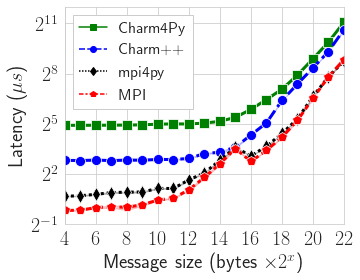

In [29]:
# Plot latency with the MPI backend, intra-socket
print(max(inter_lat[" One-way Time (us)"]))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=inter_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 16, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('log', base=2)
ax.set_ylim(0.5, 1<<12)
# ax.set_yticklabels([0,5,10,15,20])
ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
# plt.savefig('all_bw_intrasocket_chmpi.pdf', bbox_inches='tight', dpi=300)

1671.879432


Text(0.5, 0, 'Message size (bytes $\\times 2^x$)')

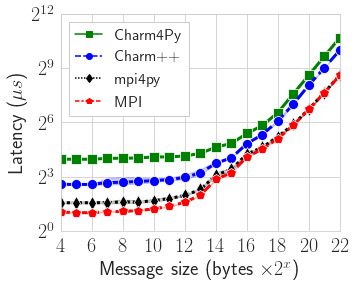

In [32]:
# Plot latency with the MPI backend, intra-socket
print(max(internode_lat[" One-way Time (us)"]))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=internode_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 16, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('log', base=2)
ax.set_ylim(1, 1<<12)
# ax.set_yticklabels([0,5,10,15,20])
ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
# plt.savefig('all_bw_intrasocket_chmpi.pdf', bbox_inches='tight', dpi=300)

- The latency reduction in intra-node figures is caused by the settings for rendezvous threshold in MPI. Setting this threshold (I_MPI_EAGER_THRESHOLD to 8192) yields best performance. intranode experiments were first done with the default settings (above), and were redone with fixed settings. The figures below are used in the paper.

In [2]:
# Latency data, used with tuned rendezvous threshold, provides best performance; used in the paper.
# Data with MPI backend
basedir = '../data/microbenchmarks/2021-08-28_latency_cleaned'
basedir_internode = '../data/microbenchmarks/2021-08-27_latency_cleaned'
read_file = lambda x: pd.read_csv(f"{basedir}/{x}", comment='#')[['Msg Size', ' One-way Time (us)']]
read_file_internode = lambda x: pd.read_csv(f"{basedir_internode}/{x}", comment='#')[['Msg Size', ' One-way Time (us)']]
rf = read_file
rf2 = read_file_internode
chpy_mpi = [rf('charm4py_intrasocket_lat.csv'), rf('charm4py_intersocket_lat.csv'),
           rf2('charm4py_internode_lat.csv')]
ch_mpi = [rf('charm_intrasocket_lat.csv'), rf('charm_intersocket_lat.csv'),
         rf2('charm_internode_lat.csv')]

mppy = [rf('mpi4py_intrasocket_lat.csv'), rf('mpi4py_intersocket_lat.csv'),
       rf2('mpi4py_internode_lat.csv')]
mp = [rf('mpi_intrasocket_lat.csv'), rf('mpi_intersocket_lat.csv'),
     rf2('mpi_internode_lat.csv')]

dfs = [*chpy_mpi, *ch_mpi, *mppy, *mp]

# Will have 2 values because MPI starts at 0 bytes, not 1.
assert(len(set([len(x) for x in dfs])) == 2)

# Build one dataframe for inter and intra containing data for every framework
chpy_mpi[0]['framework'] = 'Charm4Py'
ch_mpi[0]['framework'] = 'Charm++'
mppy[0]['framework'] = 'mpi4py'
mp[0]['framework'] = 'MPI'

chpy_mpi[1]['framework'] = 'Charm4Py'
ch_mpi[1]['framework'] = 'Charm++'
mppy[1]['framework'] = 'mpi4py'
mp[1]['framework'] = 'MPI'

chpy_mpi[2]['framework'] = 'Charm4Py'
ch_mpi[2]['framework'] = 'Charm++'
mppy[2]['framework'] = 'mpi4py'
mp[2]['framework'] = 'MPI'

intra_lat = pd.concat([chpy_mpi[0], ch_mpi[0], mppy[0], mp[0]]).reset_index(drop=True)
intra_lat = intra_lat[intra_lat['Msg Size'] >= 1<<4]
intra_lat['Msg Size'] = np.log2(intra_lat['Msg Size'])

inter_lat = pd.concat([chpy_mpi[1], ch_mpi[1], mppy[1], mp[1]]).reset_index(drop=True)
inter_lat = inter_lat[inter_lat['Msg Size'] >= 1<<4]
inter_lat['Msg Size'] = np.log2(inter_lat['Msg Size'])


internode_lat = pd.concat([chpy_mpi[2], ch_mpi[2], mppy[2], mp[2]]).reset_index(drop=True)
internode_lat = internode_lat[internode_lat['Msg Size'] >= 1<<4]
internode_lat['Msg Size'] = np.log2(internode_lat['Msg Size'])

1888.096248
[  13.65388515   13.64438735   13.8128429    13.81700995   13.77024275
   13.98077515   14.47969775   14.5969391    14.99447095   18.32434505
   19.7869011    23.02121435   29.6449134    48.7948678    91.5148186
  197.44601925  427.5820784   845.2649868  1856.6987027 ]
[   4.5577    4.5486    4.6183    4.6561    4.6141    4.615     4.9196
    5.0913    5.3809    7.8182   10.3081   13.127    19.9563   33.138
   62.2676  141.0739  288.1162  566.9726 1349.273 ]
199.57840906597627
199.96894319131155
199.08933806812036
196.7507130431047
198.43832491710197
202.94204008667387
194.32672879908938
186.70357472551217
178.66102231968637
134.38061254508708
91.95488111291122
75.37300487544758
48.5491468859458
47.247473595268275
46.97020376568231
39.95928321964587
48.40612169673207
49.08392165688433
37.607341338632
[  1.6456316    1.65900235   1.80072955   1.9325688    1.94834855
   1.963441     2.2335116    2.23332035   3.2200129    4.25950695
   5.01207865   5.9671851    8.25210345  12.

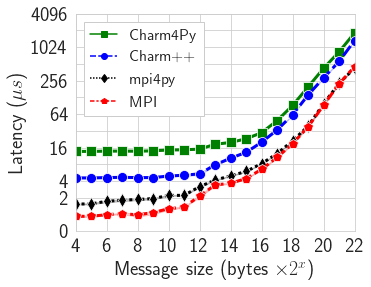

In [19]:
# Plot latency with the MPI backend, intra-socket
print(max(intra_lat[" One-way Time (us)"]))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=intra_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 16, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('symlog', base=2,linthresh=2)
ax.set_ylim(0, 1<<12)
ax.grid(True, which='major')
ax.grid(True, which='minor')
ax.set_yticks([0, 1<<1, 1<<2, 1<<4, 1<<6, 1<<8, 1<<10, 1<<12])
ax.set_yticklabels([0, 2, 4, 16, 64, 256, 1024, 4096])
ax.set_xticklabels([4,6,8,10,12,14,16,18,20,22])
ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
# plt.savefig('all_lat_intrasocket_chmpi.pdf', bbox_inches='tight', dpi=300)
lines = ax.get_lines()
chp_lat = lines[0].get_ydata()
ch_lat = lines[1].get_ydata()
print(chp_lat)
print(ch_lat)
for chp, ch in zip(chp_lat, ch_lat):
    perc_diff = 100*(chp-ch)/ch
    print(perc_diff)
    
print(mpip_lat)
print(mpi_lat)
for mpip, mpi in zip(mpip_lat, mpi_lat):
    perc_diff = 100*(mpip-mpi)/mpi
    print(perc_diff)

2192.337172
[  29.7420651    29.74555585   29.9390719    29.9050022    30.02797625
   30.3369698    31.0856609    31.959266     31.81795215   36.831611
   38.7972262    44.1703839    59.03758495   88.2645599   135.8471567
  242.20554715  477.32240555  952.8569087  2161.9896005 ]
[   7.2297    7.366     7.3237    7.3575    7.3636    7.3333    7.3861
    7.7526    7.9907   11.8018   12.7642   13.8838   19.5925   34.7059
   85.0041  166.9582  324.6916  642.8972 1576.6823]
311.3872650317441
303.82237102905236
308.79708207599987
306.4560271831465
307.78934556466953
313.6878322174192
320.8670462084185
312.2393261615459
298.1872946049784
212.08469047094513
203.95344949154668
218.14333179677038
201.3274719918336
154.32148395517763
59.812475751169664
45.06957259361924
47.00793169579995
48.21295048415205
37.12271651048535
[  1.6456316    1.65900235   1.80072955   1.9325688    1.94834855
   1.963441     2.2335116    2.23332035   3.2200129    4.25950695
   5.01207865   5.9671851    8.25210345  12.

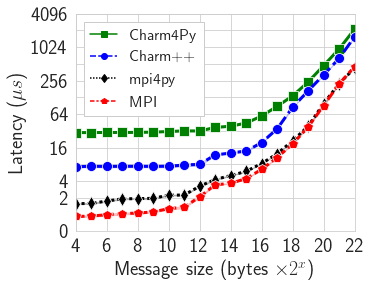

In [18]:
# Plot latency with the MPI backend, intra-socket
print(max(inter_lat[" One-way Time (us)"]))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=inter_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 16, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('symlog', base=2,linthresh=2)
ax.set_ylim(0, 1<<12)
ax.grid(True, which='major')
ax.grid(True, which='minor')
ax.set_yticks([0, 1<<1, 1<<2, 1<<4, 1<<6, 1<<8, 1<<10, 1<<12])
ax.set_yticklabels([0, 2, 4, 16, 64, 256, 1024, 4096])
ax.set_xticklabels([4,6,8,10,12,14,16,18,20,22])

ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_lat_intersocket_chmpi.pdf', bbox_inches='tight', dpi=300)

lines = ax.get_lines()
chp_lat = lines[0].get_ydata()
ch_lat = lines[1].get_ydata()
mpip_lat = lines[2].get_ydata()
mpi_lat = lines[3].get_ydata()
print(chp_lat)
print(ch_lat)
for chp, ch in zip(chp_lat, ch_lat):
    perc_diff = 100*(chp-ch)/ch
    print(perc_diff)
    
print(mpip_lat)
print(mpi_lat)
for mpip, mpi in zip(mpip_lat, mpi_lat):
    perc_diff = 100*(mpip-mpi)/mpi
    print(perc_diff)

1671.879432


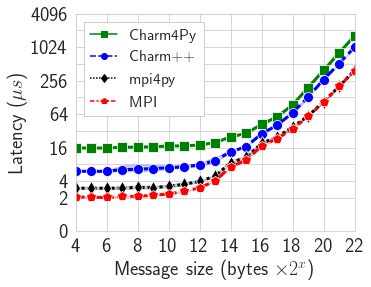

In [122]:
# Plot latency with the MPI backend, intra-socket
print(max(internode_lat[" One-way Time (us)"]))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=internode_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 16, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('symlog', base=2,linthresh=2)
ax.set_ylim(0, 1<<12)
ax.grid(True, which='major')
ax.grid(True, which='minor')
ax.set_yticks([0, 1<<1, 1<<2, 1<<4, 1<<6, 1<<8, 1<<10, 1<<12])
ax.set_yticklabels([0, 2, 4, 16, 64, 256, 1024, 4096])
ax.set_xticklabels([4,6,8,10,12,14,16,18,20,22])
ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_lat_internode_chmpi.pdf', bbox_inches='tight', dpi=300)

# GPU Benchmarks
## Bandwidth

In [6]:
# Latency data, used with tuned rendezvous threshold, provides best performance; used in the paper.
# Data with MPI backend
basedir = '../data/microbenchmarks/2021-08-31_bandwidth_gpu_cleaned'
basedir_internode = '../data/microbenchmarks/2021-08-27_latency_cleaned'
read_file = lambda x: pd.read_csv(f"{basedir}/{x}", comment='#')[['Msg Size', ' Bandwidth (MB/s)']]
read_file_internode = lambda x: pd.read_csv(f"{basedir_internode}/{x}", comment='#')[['Msg Size', ' Bandwidth (MB/s)']]
rf = read_file
rf2 = read_file_internode
chpy_mpi = [rf('charm4py_intranode_gpu_bw.csv'),
           rf('charm4py_internode_gpu_bw.csv')]
ch_mpi = [rf('charm_intranode_gpu_bw.csv'),
         rf('charm_internode_gpu_bw.csv')]

mppy = [rf('mpi4py_intranode_gpu_bw.csv'),
       rf('mpi4py_internode_gpu_bw.csv')]
mp = [rf('mpi_intranode_gpu_bw.csv'),
     rf('mpi_internode_gpu_bw.csv')]

dfs = [*chpy_mpi, *ch_mpi, *mppy, *mp]

assert(len(set([len(x) for x in dfs])) == 1)

# Build one dataframe for inter and intra containing data for every framework
chpy_mpi[0]['framework'] = 'Charm4Py'
ch_mpi[0]['framework'] = 'Charm++'
mppy[0]['framework'] = 'mpi4py'
mp[0]['framework'] = 'MPI'

chpy_mpi[1]['framework'] = 'Charm4Py'
ch_mpi[1]['framework'] = 'Charm++'
mppy[1]['framework'] = 'mpi4py'
mp[1]['framework'] = 'MPI'

# chpy_mpi[2]['framework'] = 'Charm4Py'
# ch_mpi[2]['framework'] = 'Charm++'
# mppy[2]['framework'] = 'mpi4py'
# mp[2]['framework'] = 'MPI'

intra_bw = pd.concat([chpy_mpi[0], ch_mpi[0], mppy[0], mp[0]]).reset_index(drop=True)
intra_bw = intra_bw[intra_bw['Msg Size'] >= 1<<4]
intra_bw['Msg Size'] = np.log2(intra_bw['Msg Size'])

inter_bw = pd.concat([chpy_mpi[1], ch_mpi[1], mppy[1], mp[1]]).reset_index(drop=True)
inter_bw = inter_bw[inter_bw['Msg Size'] >= 1<<4]
inter_bw['Msg Size'] = np.log2(inter_bw['Msg Size'])


# internode_lat = pd.concat([chpy_mpi[2], ch_mpi[2], mppy[2], mp[2]]).reset_index(drop=True)
# internode_lat = internode_lat[internode_lat['Msg Size'] >= 1<<4]
# internode_lat['Msg Size'] = np.log2(internode_lat['Msg Size'])

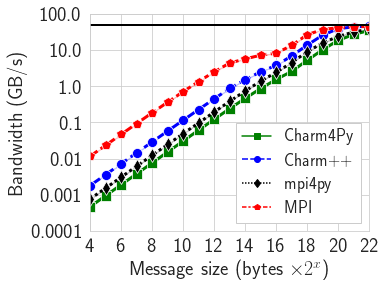

In [8]:
# Plot bandwidth with the MPI backend, inter-node
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=intra_bw,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 17, loc = 'lower right', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_xticklabels(range(4,23,2))
# ax.set_ylim(0, 50000)
ax.set_yscale('log', base=10)
ax.set_ylim(10**-1, 10**5)
ax.set_yticks([10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5])
plt.axhline(y=50000, color='black', linestyle='-', linewidth=2)
ax.set_yticklabels([0.1/1000, 1/1000, 10/1000, 100/1000, 1000/1000, 10000/1000, 100000/1000])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_bw_intranode_gpu.pdf', bbox_inches='tight', dpi=300)

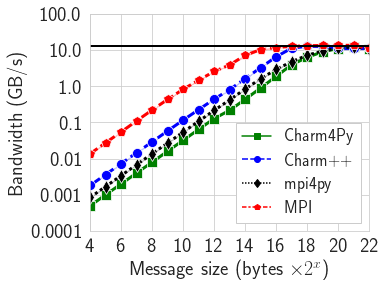

In [109]:
# Plot bandwidth with the MPI backend, inter-node
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" Bandwidth (MB/s)", data=inter_bw,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 17, loc = 'lower right', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 1)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_xticklabels(range(4,23,2))
# ax.set_ylim(0, 50000)
ax.set_yscale('log', base=10)
ax.set_ylim(10**-1, 10**5)
ax.set_yticks([10**-1, 10**0, 10**1, 10**2, 10**3, 10**4, 10**5])
plt.axhline(y=12500, color='black', linestyle='-', linewidth=2)
ax.set_yticklabels([0.1/1000, 1/1000, 10/1000, 100/1000, 1000/1000, 10000/1000, 100000/1000])
ax.set_ylabel('Bandwidth (GB/s)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_bw_internode_gpu.pdf', bbox_inches='tight', dpi=300)

## Latency

In [8]:
# Latency data, used with tuned rendezvous threshold, provides best performance; used in the paper.
# Data with MPI backend
basedir = '../data/microbenchmarks/2021-08-31_latency_gpu_cleaned'
read_file = lambda x: pd.read_csv(f"{basedir}/{x}", comment='#')[['Msg Size', ' One-way Time (us)']]
rf = read_file
chpy_mpi = [rf('charm4py_intranode_gpu_lat.csv'),
           rf('charm4py_internode_gpu_lat.csv')]
ch_mpi = [rf('charm_intranode_gpu_lat.csv'),
         rf('charm_internode_gpu_lat.csv')]

mppy = [rf('mpi4py_intranode_gpu_lat.csv'),
       rf('mpi4py_internode_gpu_lat.csv')]
mp = [rf('mpi_intranode_gpu_lat.csv'),
     rf('mpi_internode_gpu_lat.csv')]

dfs = [*chpy_mpi, *ch_mpi, *mppy, *mp]

# Will have 2 values because MPI starts at 0 bytes, not 1.
assert(len(set([len(x) for x in dfs])) == 2)

# Build one dataframe for inter and intra containing data for every framework
chpy_mpi[0]['framework'] = 'Charm4Py'
ch_mpi[0]['framework'] = 'Charm++'
mppy[0]['framework'] = 'mpi4py'
mp[0]['framework'] = 'MPI'

chpy_mpi[1]['framework'] = 'Charm4Py'
ch_mpi[1]['framework'] = 'Charm++'
mppy[1]['framework'] = 'mpi4py'
mp[1]['framework'] = 'MPI'

# chpy_mpi[2]['framework'] = 'Charm4Py'
# ch_mpi[2]['framework'] = 'Charm++'
# mppy[2]['framework'] = 'mpi4py'
# mp[2]['framework'] = 'MPI'

intra_lat = pd.concat([chpy_mpi[0], ch_mpi[0], mppy[0], mp[0]]).reset_index(drop=True)
intra_lat = intra_lat[intra_lat['Msg Size'] >= 1<<4]
intra_lat['Msg Size'] = np.log2(intra_lat['Msg Size'])

inter_lat = pd.concat([chpy_mpi[1], ch_mpi[1], mppy[1], mp[1]]).reset_index(drop=True)
inter_lat = inter_lat[inter_lat['Msg Size'] >= 1<<4]
inter_lat['Msg Size'] = np.log2(inter_lat['Msg Size'])


# internode_lat = pd.concat([chpy_mpi[2], ch_mpi[2], mppy[2], mp[2]]).reset_index(drop=True)
# internode_lat = internode_lat[internode_lat['Msg Size'] >= 1<<4]
# internode_lat['Msg Size'] = np.log2(internode_lat['Msg Size'])

156.294584274292
[ 45.81084251  45.81842422  46.09704018  45.80743313  45.90433836
  46.0889101   45.9897995   46.81736231  46.57335281  47.4075079
  49.69213009  54.02173996  61.23187542  68.97740364  71.5927124
  77.18696594  88.45281601 110.78774929 156.00337982]
[  6.828    6.861    6.8588   6.8665   6.8992   6.9353   7.0208   7.206
   7.4425   7.9092  10.2005  13.7114  20.6256  26.0258  28.5829  34.1932
  45.3922  67.6773 112.8169]
570.9262231112783
567.8097103170604
572.0860817692833
567.1147328093924
565.3574089725296
564.5553920211705
555.0506993435466
549.699726734696
525.7756508393779
499.3970047087359
387.1538658772232
293.9914229015038
196.87318390551889
165.0347103287779
150.4739281260605
125.7377664049659
94.86346995633937
63.70001357983593
38.28015113141501
[ 21.5158993   21.54340895  21.5333297   21.50823185  22.6919785
  21.6887979   21.80482755  22.53305085  24.48782065  22.40070465
  23.68185815  25.8576409   30.1534567   44.34648495  45.9005794
  51.53324755  64.606

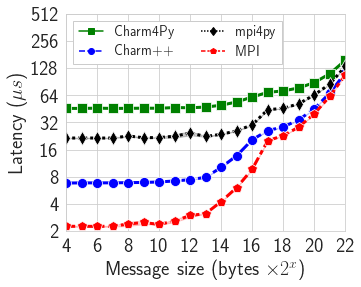

In [10]:
# Plot latency with the MPI backend, intra-socket
print(max(intra_lat[" One-way Time (us)"]))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=intra_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 14, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 2)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('log',base=2)
ax.set_ylim(2, 1<<9)
ax.grid(True, which='major')
ax.grid(True, which='minor')
ax.set_yticks([2,4,8,16,32,64,128,256,512])
ax.set_yticklabels([2, 4, 8, 16, 32, 64, 128, 256, 512])
ax.set_xticklabels([4,6,8,10,12,14,16,18,20,22])
ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
# plt.savefig('all_lat_intranode_gpu.pdf', bbox_inches='tight', dpi=300)

lines = ax.get_lines()
chp_lat = lines[0].get_ydata()
ch_lat = lines[1].get_ydata()

mpip_lat = lines[2].get_ydata()
mpi_lat = lines[3].get_ydata()
print(chp_lat)
print(ch_lat)
for chp, ch in zip(chp_lat, ch_lat):
    perc_diff = 100*(chp-ch)/ch
    print(perc_diff)
    
print(mpip_lat)
print(mpi_lat)
for mpip, mpi in zip(mpip_lat, mpi_lat):
    perc_diff = 100*(mpip-mpi)/mpi
    print(perc_diff)

497.757314


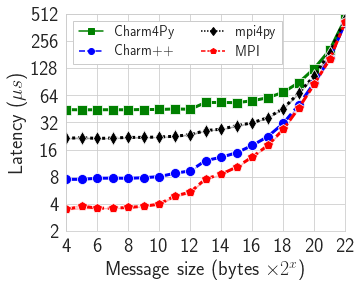

In [112]:
# Plot latency with the MPI backend, intra-socket
print(max(inter_lat[" One-way Time (us)"]))
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(5,4))
sns.lineplot(x="Msg Size", y=" One-way Time (us)", data=inter_lat,hue="framework", style="framework",
              palette = ['green','blue', 'black', 'red'],ax=ax,ci=99, markers=['s','o', 'd', 'p'],
              linewidth=3, markersize=10)
ax.legend(fontsize = 14, loc = 'upper left', fancybox = False, framealpha = 1,
              handlelength = 1.7, ncol = 2)
ax.tick_params( which = 'major', labelsize = 20 )
ax.set_xlim(4, 22)
ax.set_xticks(range(4,23,2))
ax.set_yscale('log', base=2)
ax.set_ylim(2, 1<<9)
ax.grid(True, which='major')
ax.grid(True, which='minor')
ax.set_yticks([2,4,8,16,32,64,128,256,512])
ax.set_yticklabels([2, 4, 8, 16, 32, 64, 128, 256, 512])
ax.set_xticklabels([4,6,8,10,12,14,16,18,20,22])
ax.set_ylabel('Latency ($\\mu s$)', fontsize=20)
ax.set_xlabel('Message size (bytes $\\times 2^x$)', fontsize=20)
plt.savefig('all_lat_internode_gpu.pdf', bbox_inches='tight', dpi=300)